In [77]:
import pandas as pd

# Load the data from the Excel file
ad_data = pd.read_excel("./ad-data.xlsx")

# Display top few rows of dataset
ad_data.head()

,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,product_line,task_type_en
0,20230807,1747578422390810,US,USCA,1.0,2023-07-24,5132.1700,4795.250,2022-10-24 14:36:00,1.78,Auction Ads,auction_relation
1,20230807,1758543228094480,SA,MENA,1.0,2023-06-14,1976.2500,1063.767,2023-02-22 15:50:00,1.67,RIE,Ad Group Recall (Merged)
2,20230807,1738303151826990,AU,AU,2.0,2023-07-24,1.7355,5.365,2022-07-14 05:00:00,1.84,Auction Ads,auction_relation
3,20230807,1738303920938010,NZ,NZ,2.0,2023-07-24,NaN,5.365,2022-07-14 05:16:00,1.58,Auction Ads,auction_relation
4,20230807,1738304016410620,NZ,NZ,2.0,2023-07-24,1.5250,5.365,2022-07-14 05:17:00,1.58,Auction Ads,auction_relation


# EDA
When first dealing with any dataset, it is important to do **Exploratory Data Analysis (EDA)**. Below are the column definitions for easy reference:

`p_date`: The date of ads creation (where advertiser launches an ad campaign on Ads Manager)

`ad_id`: A unique identifier for a TikTok video advertisement (aka. ad group)

`delivery_country`: The country where the advertiser would like the ad delivered

`queue_market`: The country or region where the advertiser would like the ad delivered

`punish_num`: In the last 90 days, how many times has the advertiser of this newly created ad been punished (mostly in the form of temporary account suspension)

`latest_punish_begin_date`:  The latest punish begin date of the advertiser. If there is no punish record for this advertiser in the past 90 days, the date is 2000/1/1

`ad_revenue`: How much US dollars did the ad generate for TikTok as a platform (through view, clicks, etc.)

`avg_ad_revenue`: Average ad revenue that TikTok recoups from the advertiser over the last 30 days

`start_time`: When does the advertiser want to have the delivered from?

`baseline_st`: ST, represents task complexity

`product_line`: What kind of ads product is being used, for example livestream ads? E-commerce ads? (We don't need to incorporate this field into modeling)

`task_type_en`: What kind of ads product is being used, for example livestream ads? E-commerce ads? (more detailed) (We don't need to incorporate this field into modeling)

# General overview

In [78]:
# General overview of the dataset
overview = ad_data.info()

# Displaying basic statistics of the dataset
statistics = ad_data.describe(include='all', datetime_is_numeric=True)

overview, statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40679 entries, 0 to 40678
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   p_date                    40679 non-null  int64         
 1   ad_id                     40679 non-null  int64         
 2   delivery_country          40679 non-null  object        
 3   queue_market              19524 non-null  object        
 4   punish_num                2393 non-null   float64       
 5   latest_punish_begin_date  40679 non-null  datetime64[ns]
 6   ad_revenue                29908 non-null  float64       
 7   avg_ad_revenue            40679 non-null  float64       
 8   start_time                34004 non-null  datetime64[ns]
 9   baseline_st               40679 non-null  float64       
 10  product_line              40679 non-null  object        
 11  task_type_en              40679 non-null  object        
dtypes: datetime64[ns](

(None,
             p_date         ad_id delivery_country queue_market  punish_num  \
 count      40679.0  4.067900e+04            40679        19524  2393.00000   
 unique         NaN           NaN               59           51         NaN   
 top            NaN           NaN               US        Other         NaN   
 freq           NaN           NaN             3987         1855         NaN   
 mean    20230807.0  1.772982e+15              NaN          NaN     1.14041   
 min     20230807.0  1.697828e+15              NaN          NaN     1.00000   
 25%     20230807.0  1.773396e+15              NaN          NaN     1.00000   
 50%     20230807.0  1.773532e+15              NaN          NaN     1.00000   
 75%     20230807.0  1.773564e+15              NaN          NaN     1.00000   
 max     20230807.0  1.773617e+15              NaN          NaN    16.00000   
 std            0.0  2.562183e+12              NaN          NaN     0.84125   
 
              latest_punish_begin_date    a

1. **Missing Values**
- There are missing values in the columns `queue_market`, `punish_num`, `ad_revenue`, and `start_time`

2. **General Statistics**
- `p_date` has only one unique value, which means all data is from the same date
- `ad_id` has some duplicates since there are fewer unique values than the total count
- The most common delivery country is the US.
- `punish_num` mostly has a value of 1, indicating that most advertisers were punished once
- The `latest_punish_begin_date` has a frequent value of 2000-01-01, which represents no punish record for the advertiser in the past 90 days
- There are multiple `ad_revenue` and `avg_ad_revenue` values set to 0
- `baseline_st` has a frequent value of 0.54
- The most common product type is Non-Auction Ads.
- The most common task type is Promote.

# Examining and Imputing Missing Values

In [79]:
# Checking the number of missing values in each column
missing_values = ad_data.isnull().sum()

# Calculating the percentage of missing values for each column
missing_percentage = (ad_data.isnull().sum() / len(ad_data)) * 100

# Combining the count and percentage into a DataFrame for better visualization
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage})

# Filtering out columns with no missing values
missing_data = missing_data[missing_data['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

missing_data

,Missing Values,Percentage (%)
punish_num,38286,94.117358
queue_market,21155,52.004720
ad_revenue,10771,26.478035
start_time,6675,16.408958


To deal with the missing values, we can do the following: 
1. `punish_num`: Impute missing values with 0
2. `queue_market`: Impute missing values with "Unknown"
3. `ad_revenue`: If we assume that a missing value in ad revenue means no revenue was generated, we can impute with 0

In [80]:
# Imputing missing values based on the discussed strategies

# Imputing punish_num with 0
ad_data['punish_num'].fillna(0, inplace=True)

# Imputing queue_market with 'Unknown'
ad_data['queue_market'].fillna('Unknown', inplace=True)

# Imputing ad_revenue with 0
ad_data['ad_revenue'].fillna(0, inplace=True)

# Dealing with Duplicate Rows

In [81]:
# Checking for completely duplicated rows
duplicated_rows = ad_data[ad_data.duplicated()]

# Checking how many of the duplicated rows have the same ad_id
duplicate_ad_ids = duplicated_rows['ad_id'].nunique()

duplicated_rows.shape[0], duplicate_ad_ids

(1115, 874)

There are 1,115 rows that are completely duplicated across all columns. Among these rows, there are 874 unique `ad_id` values, indicating that some ad_id values have more than one duplicate.

In [82]:
# Deleting the duplicated rows
ad_data = ad_data.drop_duplicates()

# Verifying the removal of duplicates
remaining_duplicates = ad_data[ad_data.duplicated()]

remaining_duplicates.shape[0]

0

# Distribution Analysis of Numerical Features

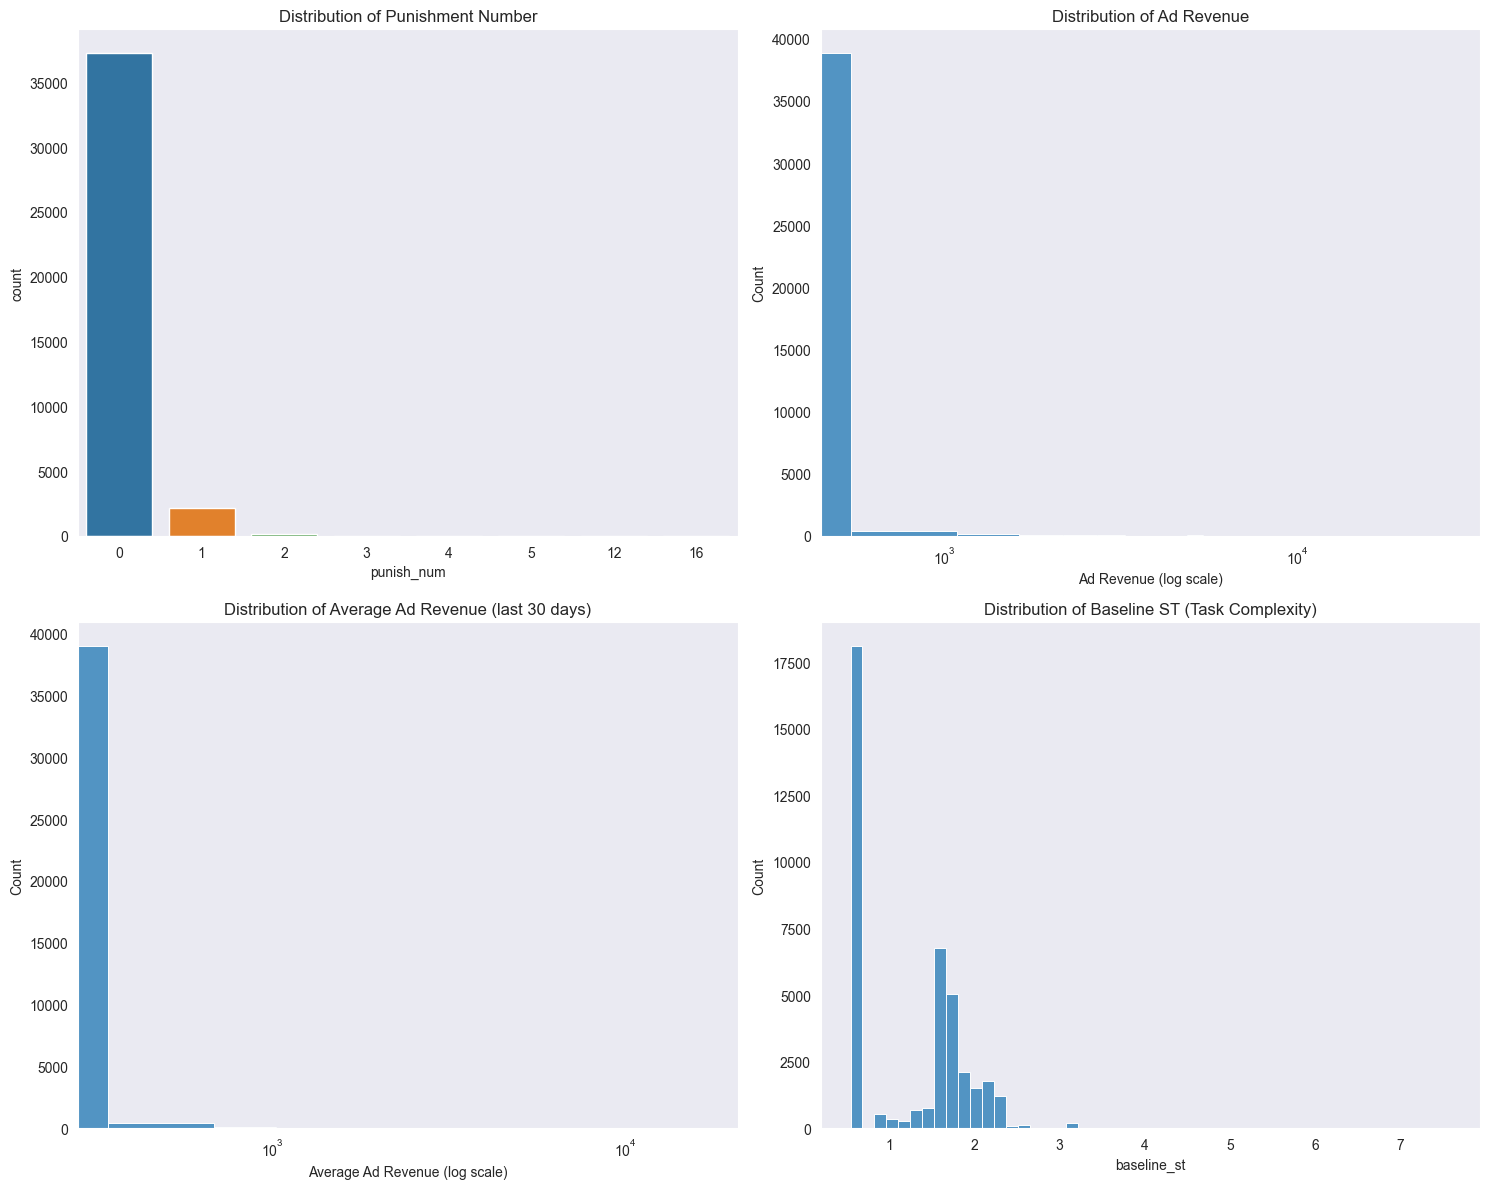

In [83]:
# Converting columns to appropriate data types
ad_data['p_date'] = pd.to_datetime(ad_data['p_date'], format='%Y%m%d')
ad_data['punish_num'] = pd.to_numeric(ad_data['punish_num'], errors='coerce', downcast='integer')
ad_data['ad_revenue'] = pd.to_numeric(ad_data['ad_revenue'], errors='coerce')
ad_data['avg_ad_revenue'] = pd.to_numeric(ad_data['avg_ad_revenue'], errors='coerce')
ad_data['baseline_st'] = pd.to_numeric(ad_data['baseline_st'], errors='coerce')

# Plotting distribution of key numerical features
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

plt.figure(figsize=(15, 12))

# Distribution of punish_num
plt.subplot(2, 2, 1)
sns.countplot(data=ad_data, x='punish_num')
plt.title('Distribution of Punishment Number')

# Distribution of ad_revenue
plt.subplot(2, 2, 2)
sns.histplot(data=ad_data, x='ad_revenue', bins=50)
plt.title('Distribution of Ad Revenue')
plt.xscale('log')
plt.xlabel('Ad Revenue (log scale)')

# Distribution of avg_ad_revenue
plt.subplot(2, 2, 3)
sns.histplot(data=ad_data, x='avg_ad_revenue', bins=50)
plt.title('Distribution of Average Ad Revenue (last 30 days)')
plt.xscale('log')
plt.xlabel('Average Ad Revenue (log scale)')

# Distribution of baseline_st
plt.subplot(2, 2, 4)
sns.histplot(data=ad_data, x='baseline_st', bins=50)
plt.title('Distribution of Baseline ST (Task Complexity)')

plt.tight_layout()
plt.show()

Before doing the distribution analysis, the columns have to be converted to their appropriate data types (currently are `object` data type).

Below are some insights:
1. Punishment Number (`punish_num`): 
- Most advertisers have not been punished in the last 90 days
- Few advertisers have been punished multiple times,with a maximum of 7 times

2. Ad Revenue (`ad_revenue`):
- The distribution of ad revenue is right-skewed, with many ad campaigns generating low revenue
- By applying a log scale on the x-axis, we can see that a significant portion of the ads has very low revenue, but there are some outliers that have high revenue

3. Average Ad Revenue (`avg_ad_revenue`):
- Similar to the ad revenue, the average ad revenue over the last 30 days is also right-skewed
- There are many ad campaigns with a low average revenue, and a few campaigns have a high average revenue

4. Baseline ST (Task Complexity) (`baseline_st`):
- The distribution shows that many tasks have a complexity value close to 0.5, but there's a good spread across different complexities as well

# Analysis of Categorical Features

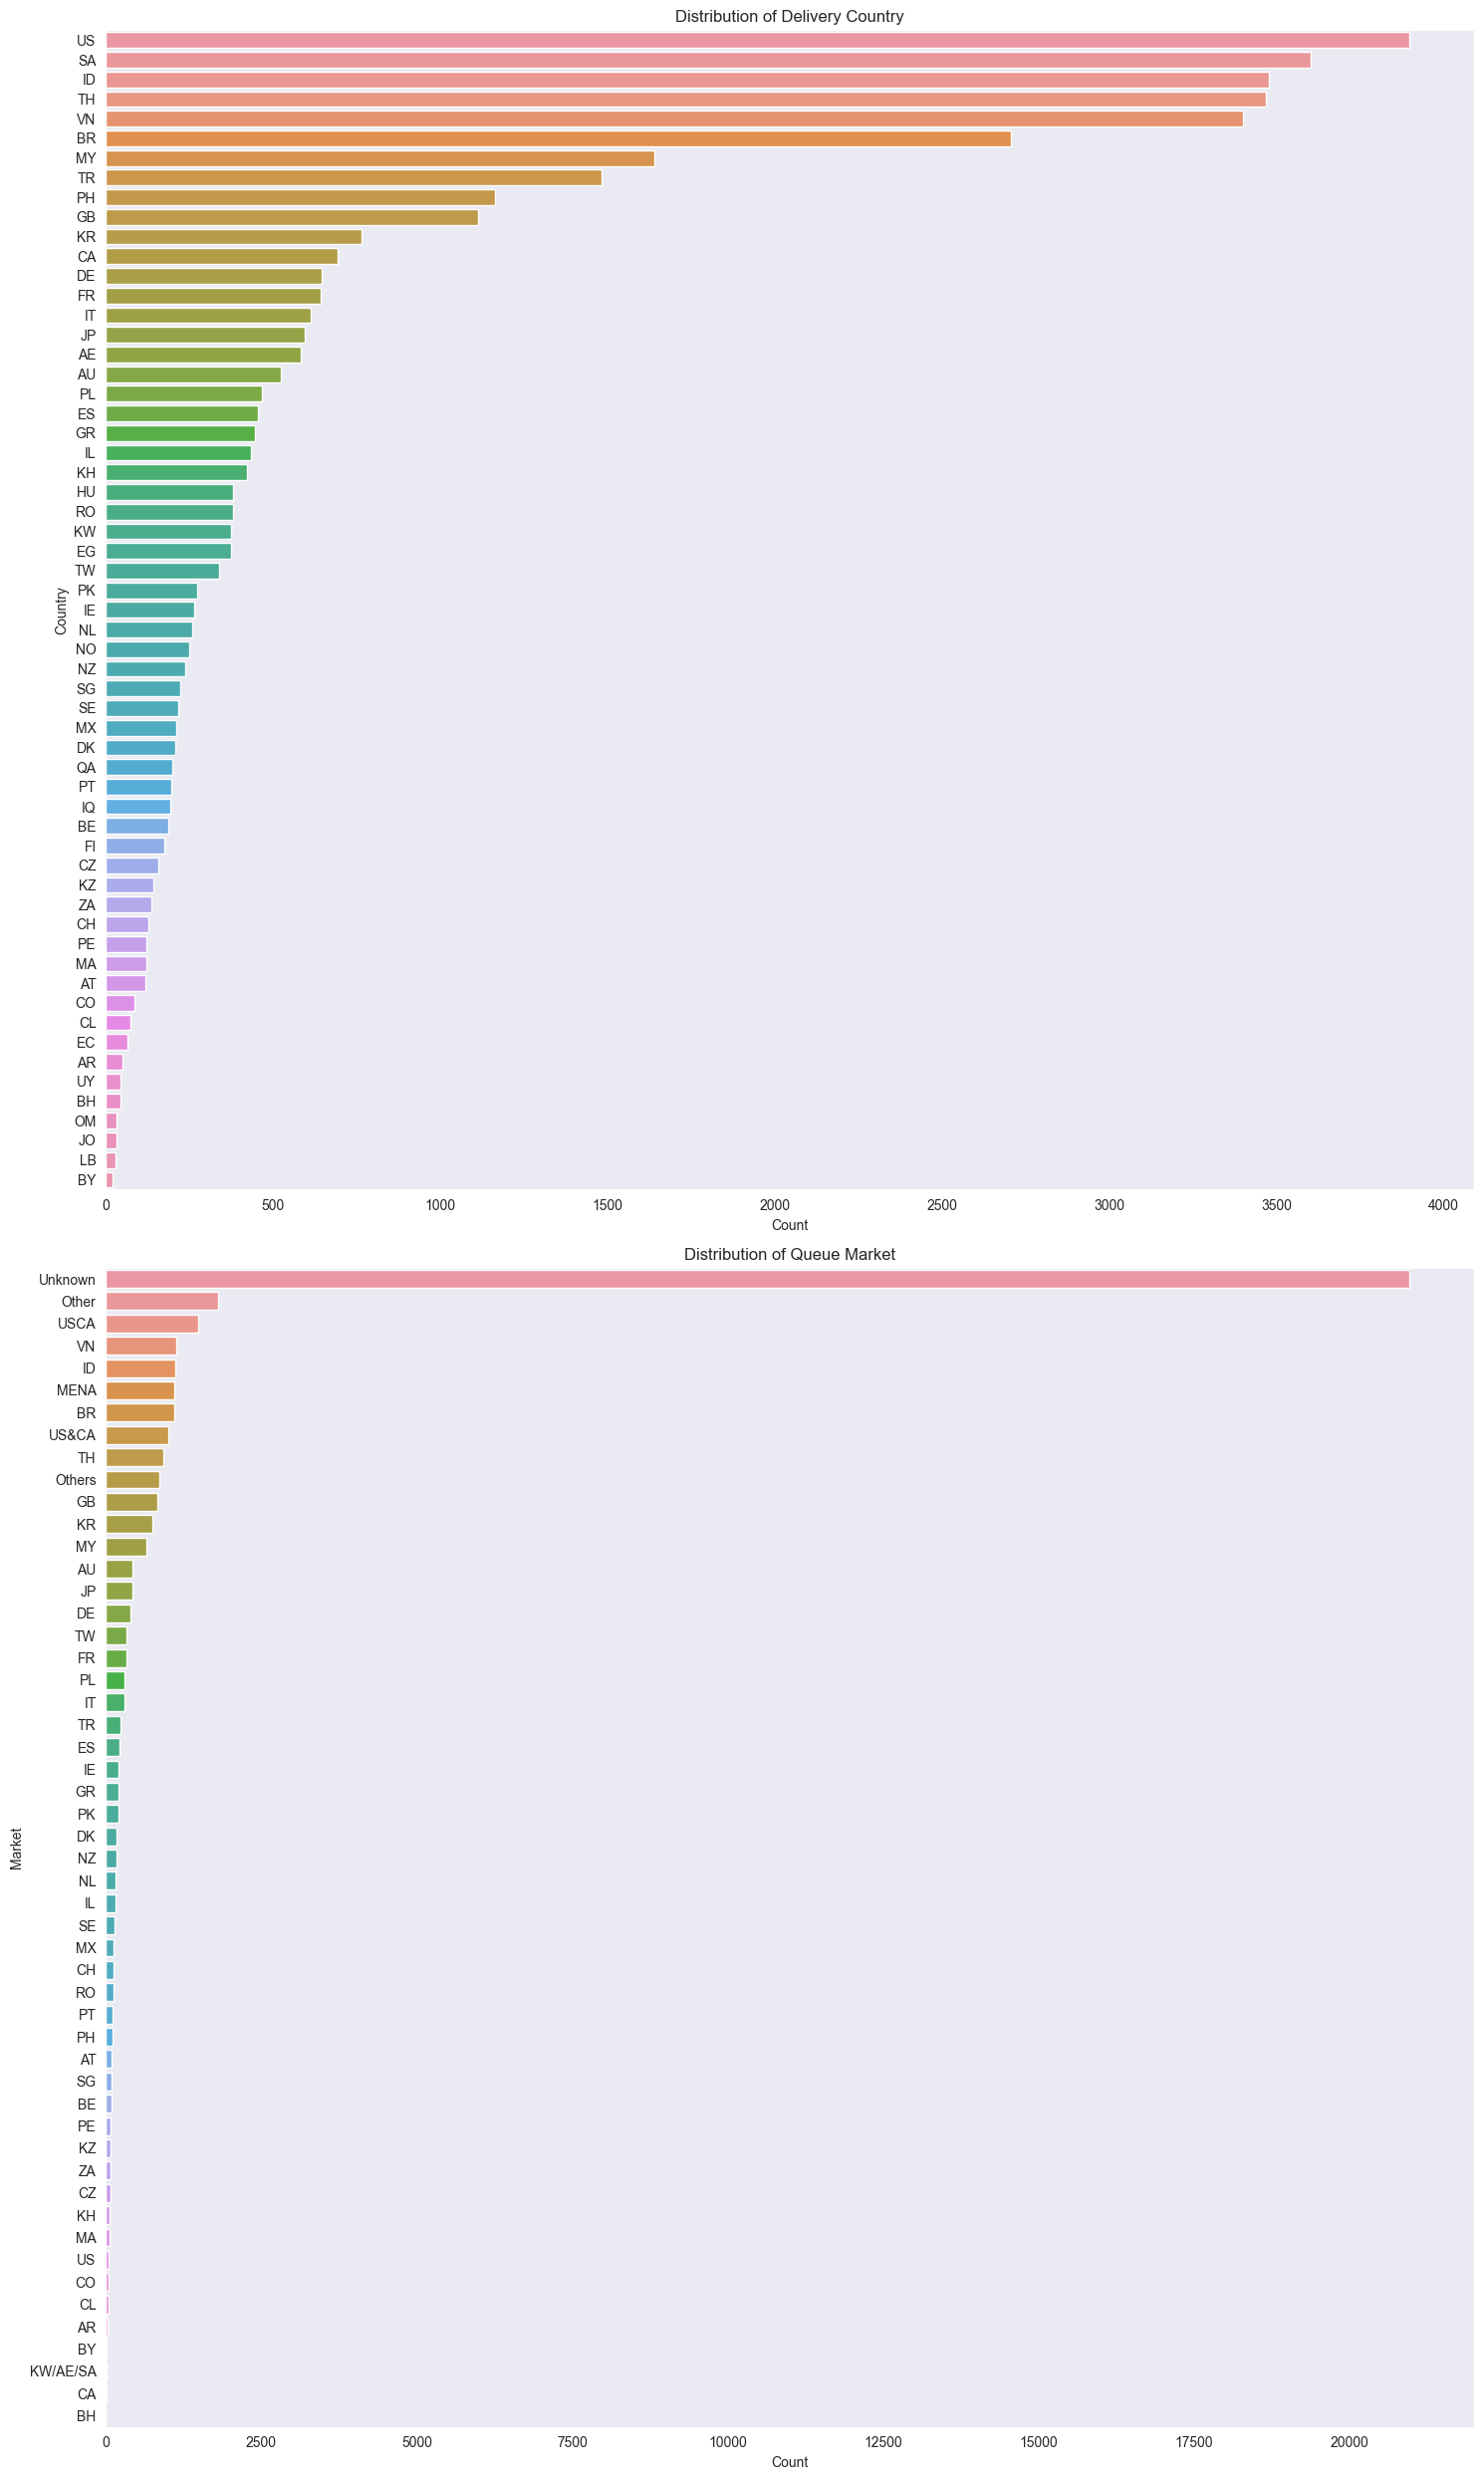

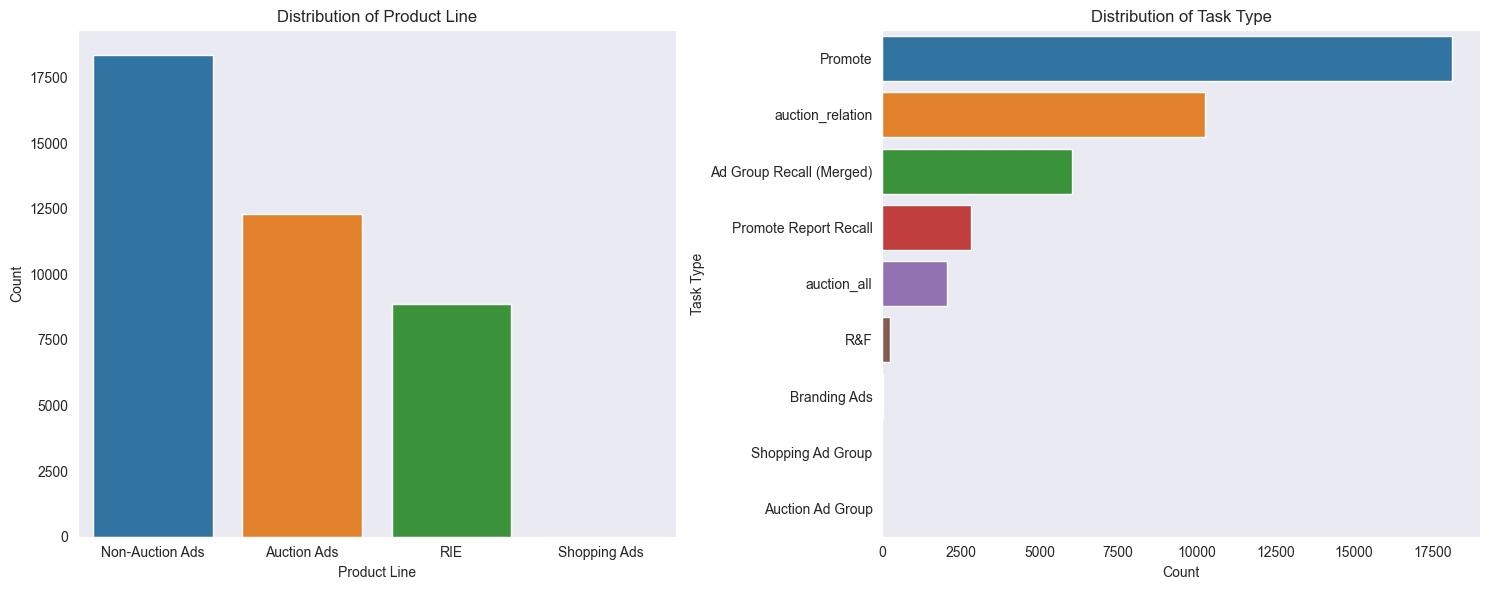

In [84]:
# Plotting distribution of key categorical features
plt.figure(figsize=(15, 25))

# Distribution of delivery_country
plt.subplot(2, 1, 1)
sns.countplot(data=ad_data, y='delivery_country', order=ad_data['delivery_country'].value_counts().index)
plt.title('Distribution of Delivery Country')
plt.xlabel('Count')
plt.ylabel('Country')

# Distribution of queue_market
plt.subplot(2, 1, 2)
sns.countplot(data=ad_data, y='queue_market', order=ad_data['queue_market'].value_counts().index)
plt.title('Distribution of Queue Market')
plt.xlabel('Count')
plt.ylabel('Market')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))

# Distribution of product_line
plt.subplot(1, 2, 1)
sns.countplot(data=ad_data, x='product_line', order=ad_data['product_line'].value_counts().index)
plt.title('Distribution of Product Line')
plt.xlabel('Product Line')
plt.ylabel('Count')

# Distribution of task_type_en
plt.subplot(1, 2, 2)
sns.countplot(data=ad_data, y='task_type_en', order=ad_data['task_type_en'].value_counts().index)
plt.title('Distribution of Task Type')
plt.xlabel('Count')
plt.ylabel('Task Type')

plt.tight_layout()
plt.show()

1. Delivery Country (`delivery_country`):
- The US appears to be the predominant country where advertisers want their ads delivered, followed by countries like India, Brazil, and the UK 
- Many countries have relatively fewer ads

2. Queue Market (`queue_market`):
- Most of the queue markets are "Unknown" due to missing data
- The "Other" category dominates the queue market, followed by markets like USCA, MENA, and SEA

3. Product Line (`product_line`):
- "Non-Auction Ads" is the most common type of product line, followed by "Auction Ads"
- There's also a significant number of "RIE" and "DIY Video" product lines

4. Task Type (`task_type_en`):
- "Promote" is the predominant task type
- Other task types, such as "auction_relation" and "Ad Group Recall (Merged)", also have significant counts

# Time-Series Analysis on Start Time

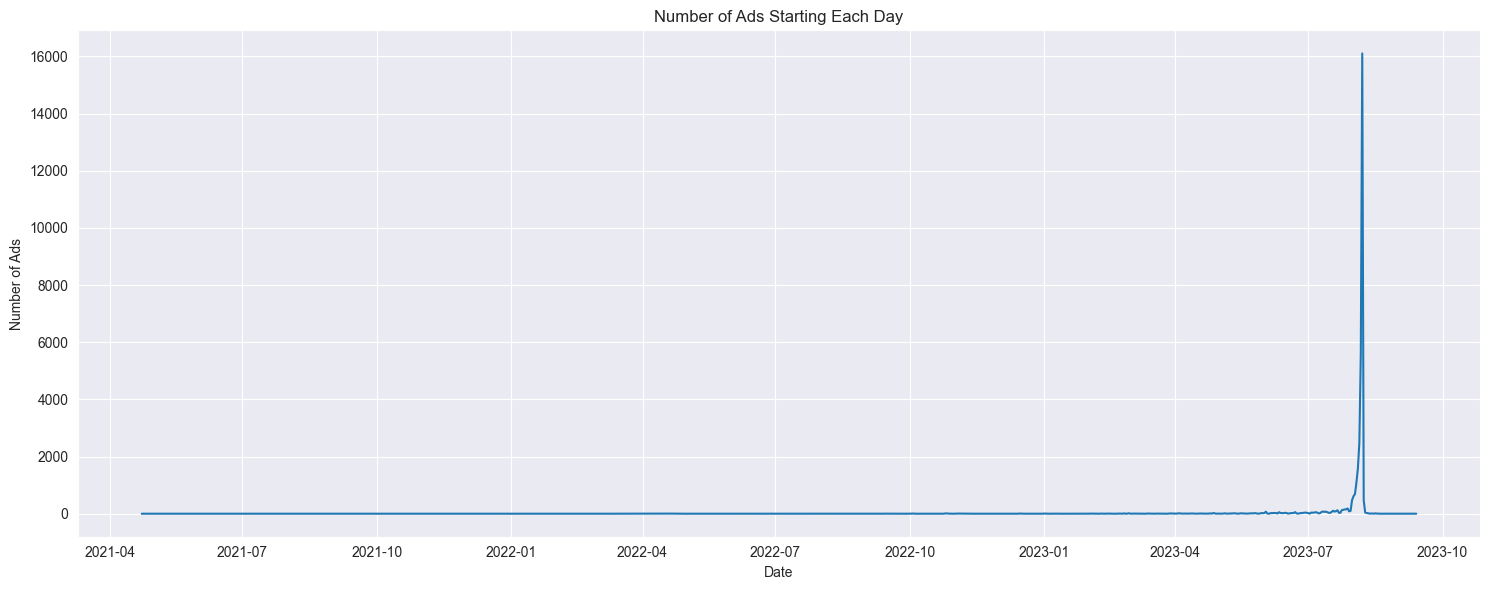

In [85]:
# Converting start_time to datetime type and extracting the date part
ad_data['start_date'] = pd.to_datetime(ad_data['start_time']).dt.date

# Grouping by start_date and counting the number of ads
ads_by_date = ad_data.groupby('start_date').size()

# Plotting the time series of ads starting each day
plt.figure(figsize=(15, 6))
ads_by_date.plot()
plt.title('Number of Ads Starting Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Ads')
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
# Extracting the date part from start_time and finding the most common date
most_common_date = ad_data['start_time'].dt.date.value_counts().idxmax()
most_common_date_count = ad_data['start_time'].dt.date.value_counts().max()

most_common_date, most_common_date_count

(datetime.date(2023, 8, 7), 16103)

We can perform a time series analysis on the `start_time` column to understand if there are any trends or patterns in when advertisers prefer to start their campaigns. Below are some insights:

- There is a huge peak on August 7, 2023, a total of 16,621 ads were started on that day
- Apart from that, there are certain smaller peaks, indicating specific days where there's a surge in the number of ads starting. These could be associated with specific events, promotions, or trends

# Correlation Matrix of the Numerical Features

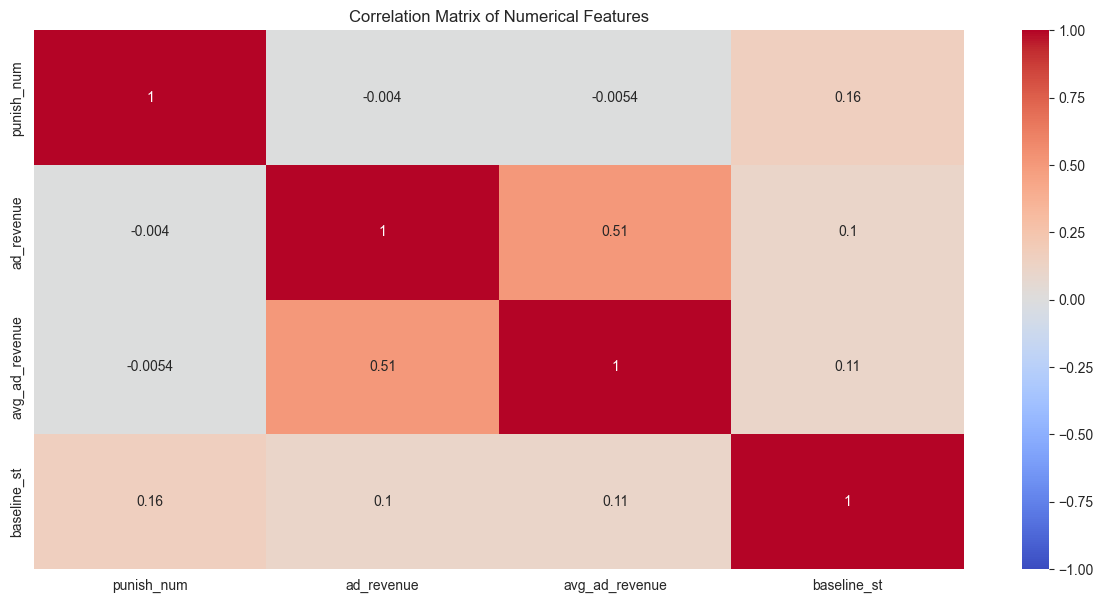

In [87]:
# Calculating the correlation matrix for the numerical features
correlation_matrix = ad_data[['punish_num', 'ad_revenue', 'avg_ad_revenue', 'baseline_st']].corr()

# Plotting the heatmap for the correlation matrix
plt.figure(figsize=(15, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

1. `punish_num` & `ad_revenue`:
- There's a slight negative correlation between the number of times an advertiser has been punished and the ad revenue
- This might suggest that advertisers with a higher number of punishments tend to generate slightly less revenue, but the relationship is very weak

2. `avg_ad_revenue` & `ad_revenue`:
- As expected, there's a strong positive correlation between the average ad revenue over the last 30 days and the ad revenue

3. `baseline_st` (Task Complexity):
- Task complexity doesn't seem to have a strong correlation with any of the other features
- This indicates that the complexity of the task might be independent of factors like ad revenue or the number of times an advertiser has been punished

# Baseline ST Computation
Interestingly, one observation we noticed was how the `baseline_st` score was calculated. We noticed that for every unique combination of `delivery_country`, `product_line`, and `task_type_en`, it will always have the same `baseline_st`. Let's verify this.

In [88]:
# Grouping the data by 'delivery_country', 'product_line', and 'task_type_en' 
# and checking the number of unique 'baseline_st' values for each group
unique_baseline_counts = ad_data.groupby(['delivery_country', 'product_line', 'task_type_en'])['baseline_st'].nunique()

# Checking if any group has more than one unique 'baseline_st' value
groups_with_multiple_baseline = unique_baseline_counts[unique_baseline_counts > 1]

groups_with_multiple_baseline

delivery_country  product_line  task_type_en            
AU                RIE           Ad Group Recall (Merged)    2
Name: baseline_st, dtype: int64

It seems that almost all combinations of `delivery_country`, `product_line`, and `task_type_en` have a unique `baseline_st` value, except for one combination:

`delivery_country` = AU

`product_line` = RIE

`task_type_en` = Ad Group Recall (Merged)

This combination has two distinct `baseline_st` values.

Given this finding, let's create a table displahying the unique combinations of `delivery_country`, `product_line`, `task_type_en`, and their associated `baseline_st` values.

In [90]:
# Creating a table with unique combinations of 'delivery_country', 'product_line', 'task_type_en', 
# and their associated 'baseline_st' values
unique_combinations = ad_data.drop_duplicates(subset=['delivery_country', 'product_line', 'task_type_en', 'baseline_st'])[['delivery_country', 'product_line', 'task_type_en', 'baseline_st']]

unique_combinations = unique_combinations.sort_values('baseline_st')
unique_combinations.reset_index(drop=True, inplace=True)
unique_combinations

,delivery_country,product_line,task_type_en,baseline_st
0,MY,Non-Auction Ads,Promote,0.54
1,TH,Non-Auction Ads,Promote,0.54
2,US,Non-Auction Ads,Promote,0.54
3,DE,Non-Auction Ads,Promote,0.54
4,TR,Non-Auction Ads,Promote,0.54
...,...,...,...,...
250,ES,Non-Auction Ads,Branding Ads,5.96
251,MY,Non-Auction Ads,Branding Ads,5.96
252,SE,Non-Auction Ads,Branding Ads,5.96
253,IT,Non-Auction Ads,Branding Ads,7.59
